## Krylov 子空间

记号. $\mathcal K(A,x,k) = {\rm span}\{x,Ax,A^2x,\dotsc,A^{k-1}x\}$ 称为一个 Krylov 子空间.

**Theorem 1** $\mathcal K(A,x,k)\subset K(A,x,k+1)$.

**Theorem 2** 若 $A$ 的极小多项式次数为 $k$, 则 $\forall m\geqslant k$, $\mathcal K(A,x,m) =\mathcal K(A,x,k)$.

证: 假设极小多项式为 $$A^k + a_{k-1}A^{k-1} + \dotsc + a_1A + a_0I = O$$
那么显然 $A^kx$ 可以由 $x,Ax,\dotsc,A^{k-1}x$ 线性表出. 同理 $\forall m, A^mx$ 也可以.

<br>

### Arnoldi 过程

目标: 矩阵 $A$ 是 $n\times n$ 的方阵, 求得 $n\times (k+1) $ 的正交列向量构成的矩阵
 $Q_{k+1} = [q_1,q_2\dotsc,q_{k+1}]$ , 使得 
$AQ_k = Q_{k+1}\widetilde H_k$.

其中 $Q_k =  [q_1,q_2\dotsc,q_{k}]$ 是前 $k$ 列. 而 $\widetilde H_k$ 是如下结构的上 Hessenberg 矩阵:

$$\widetilde H_k = \left[\begin{matrix} h_{11}  &  h_{12} &  \dotsc  &  h_{1,k-1} &  h_{1k} \\
 h_{21} &  h_{22}  &  \dotsc  &  h_{2,k-1} &  h_{2k} \\
\ &  h_{32}  &  \dotsc  &  h_{3,k-1}  &  h_{3k} \\
\ &   & \ddots &\vdots & \vdots\\
\ &   &   &  h_{k,k-1}  &  h_{kk} \\
\ &   &   &   &  h_{k+1,k} \end{matrix}\right]\in \mathbb C^{(k+1)\times k}.$$

而

$$AQ_k = [Aq_1,Aq_2,\dotsc,Aq_k] = [q_1,q_2,\dotsc,q_k]\widetilde H_k.$$

显然 $Aq_1$ 是 $q_1,q_2$ 的线性组合, $Aq_2$ 是 $q_1,q_2,q_3$ 的线性组合 ... $Aq_k$ 是 $q_1,\dotsc ,q_{k+1}$ 的线性组合. 因此 
$AQ_k = Q_{k+1}\widetilde H_k$ 也可写作 $$AQ_k = Q_kH_k + h_{k+1,k} q_{k+1}e_k^*.$$

从而

$$Q_k^*AQ_k = H_k.$$

<br>

从线性组合的角度, 容易发现求解 $q_{k+1}$ 的步骤与 Gram-Schmidt 相近:
$$Aq_k = h_{1k}q_1 + h_{2k}q_2 +\dotsc + h_{kk}q_k + h_{k+1,k}q_{k+1}.$$
$$h_{ik} = q_i^*Aq_k\quad (i\leqslant k).$$
$$h_{k+1,k}q_{k+1} = Aq_k - \sum_{i=1}^k h_{ik}q_i.$$


In [2]:
import numpy as np
# 找到 Q,H 使得 Q^* A Q = H
def Arnoldi(A,k=-1):
    n = A.shape[0]
    if k < 0 or k > n: k = n
    Q = np.zeros((n,k),dtype=A.dtype)
    H = np.zeros((k,k),dtype=A.dtype)
    # 初始化第一列
    Q[:,0] = np.random.randn(n)
    Q[:,0] /= np.linalg.norm(Q[:,0])
    for i in range(k):
        H[:i+1,i] = Q[:,:i+1].T.conj() @ A @ Q[:,i]
        if i + 1 < k :
            Q[:,i+1] = A @ Q[:,i] - Q[:,:i+1] @ H[:i+1,i]
            H[i+1,i] = np.linalg.norm(Q[:,i+1])
            Q[:,i+1] /= H[i+1,i]
    return Q , H


n , k = 50 , 30
np.random.seed(0)
A = (np.random.randn(n*n)+np.random.randn(n*n)*1j).reshape((n,n))
Q, H = Arnoldi(A,30)
print('Orthogonaliy Loss =',np.linalg.norm(Q.T.conj() @ Q - np.eye(k)))
print('||Q*AQ - H|| =',np.linalg.norm(Q.T.conj() @ A @ Q - H))

Orthogonaliy Loss = 3.931522835259797e-15
||Q*AQ - H|| = 2.865885625235656e-14


归纳易见 Arnoldi 过程中, 
$${\rm span}\{q_1,q_2,\dotsc,q_k\} = {\rm span}\{q_1,Aq_1,\dotsc,A^{k-1}q_1\} = \mathcal K(A,q_1,k).$$

特别地, 由 **Theorem 2**, 若设 $A$ 的极小多项式次数为 $m$, 则$${\rm span}\{q_1,q_2,\dotsc,q_{m+1}\} ={\rm span}\{q_1,q_2,\dotsc,q_{m}\}.$$

但 $q_{m+1}$ 应与 $q_i\ (i\leqslant m)$ 均正交, 这说明 $q_{m+1} = 0$. 即 Arnoldi 过程终止. 此时 $AQ_m = Q_mH_m$, 其中 $H_m\in \mathbb C^{m\times m}$. 

### GMRES

对于方程 $Ax = b$, 可以按如下方法求得近似解. 假设 Arnoldi 过程得到 $AQ_k = Q_{k+1}\widetilde H_k$. 若存在 $x_0$, 使 $q_1 = \frac{b-Ax_0}{\Vert b- Ax_0\Vert_2}=\frac{r_0}{\Vert r_0\Vert_2}$, 则 
$${\rm span}\{q_1,\dotsc,q_k\} = \mathcal K(A,r_0,k).$$

在子空间 $x_0+\mathcal K(A,r_0,k)$ 中求解最小二乘问题 $\Vert Ax - b\Vert$:
$$\Vert A(x_0 + Q_ky) - b\Vert_2 = \Vert Q_{k+1}\widetilde H_ky - r_0 \Vert_2
=\Vert \widetilde H_ky - \beta e_1\Vert_2.$$

最后一步是因为 $r_0$ 与 $Q_{k+1}$ 第一列平行, 故 $Q_{k+1}^*r_0 = \beta e_1$, 其中 $\beta = \Vert r_0\Vert_2$.

$\Vert \widetilde H_ky - \beta e_1\Vert_2$ 的最小值还是最小二乘问题, 而 $\widetilde H_k$ 是 Hessenberg 矩阵, 可以通过 $k$ 次 Givens 变换变成上三角阵形成 QR 分解. 详见 [2] p. 643.

### Lanczos 过程

若 $A$ 是 Hermite 矩阵, 则 $H_k = Q_k^*AQ_k$ 是 Hermite 的上 Hessenberg 矩阵, 因此必为三对角矩阵. 此时的 Arnoldi 过程称为 Lanczos 过程.

$$AQ_k = Q_k\left[\begin{matrix} \alpha_1  &  \beta_1 &   &  & \\
 \beta_1 & \alpha_2 & \beta_2 &   & \\
\ &  \beta_2  &  \alpha_3 &  \ddots &   \\
\ &   & \ddots &\ddots & \beta_{k-1} \\
\ &   &   &  \beta_{k-1}  &  \alpha_{k} \\
\ &   &   &   &  \beta_k \end{matrix}\right].$$

可见, $Aq_k = \beta_{k-1}q_{k-1}+\alpha_kq_k +\beta_{k}q_{k+1}\ (k>1)$, 故 
$$\alpha_k = q_k^*Aq_k$$
$$\beta_kq_{k+1} = Aq_k - \beta_{k-1}q_{k-1} -\alpha_kq_k$$

这是短递推, 有如下优点:
1. 如果只需要求 $H_k$ 而不需要正交矩阵, 则无需记录所有 $q$, 因为每步只用到上两个 $q$: $q_{k-1},q_k$. 节省内存.
2. 运算量少, 效率高.

但相比一般的 Arnoldi 也有缺点:
1. 计算时默认且利用了列向量正交的假设, 但舍入误差的存在会使正交阵的正交性逐渐变差.

In [1]:
import numpy as np
# 找到 Q,H 使得 Q^* A Q = H , 需要 A 是 Hermite矩阵
def Lanczos(A,k=-1):
    n = A.shape[0]
    if k < 0 or k > n: k = n
    Q = np.zeros((n,k),dtype=A.dtype)
    H = np.zeros((k,k),dtype=A.dtype)
    # 初始化第一列
    Q[:,0] = np.random.randn(n)
    Q[:,0] /= np.linalg.norm(Q[:,0])
    for i in range(k):
        H[i,i] = Q[:,i].T.conj() @ A @ Q[:,i] 
        if i + 1 < k :
            Q[:,i+1] = A @ Q[:,i] - H[i,i] * Q[:,i]
            if i > 0:
                Q[:,i+1] -= H[i,i-1] * Q[:,i-1]
            H[i+1,i] = np.linalg.norm(Q[:,i+1])
            H[i,i+1] = H[i+1,i]
            Q[:,i+1] /= H[i+1,i]
    return Q , H


n , k = 50 , 30
np.random.seed(0)
A = (np.random.randn(n*n)+np.random.randn(n*n)*1j).reshape((n,n))
A = (A + A.T.conj()) * 0.5
Q, H = Lanczos(A,30)
print('Orthogonaliy Loss =',np.linalg.norm(Q.T.conj() @ Q - np.eye(k)))
print('||Q*AQ - H|| =',np.linalg.norm(Q.T.conj() @ A @ Q - H))

Orthogonaliy Loss = 1.6302096042761702e-10
||Q*AQ - H|| = 2.1444299264284427e-09


## 梯度法

### 最速下降法 (Steepest Descent, SD)

若 $A$ 是**实对称正定**的矩阵, 求解 $Ax = b$ 可以看成求最小二乘法的解: $f(x) = x^TAx - 2x^Tb$ 的极值点. 最小二乘问题是优化问题, 可以用其它方法求得近似解. 在此仍然使用迭代法, 假定现解出一个近似解 $x$. 

由于负梯度方向是函数减少最快的方向, $\nabla f = 2Ax - 2b$, 可以考虑一步迭代得到 $x' = x - \alpha r$, 其中 $\alpha 是参数$, $r = Ax - b$.

希望 $\Vert Ax'-b\Vert_2$ 尽量小, 而 
$$f(x') - f(x) = x'^TAx' - x^TAx - 2(x' - x)^Tb. $$

代入 $x' = x - \alpha r$, 其中 $r = Ax - b$, 得

$$f(x') - f(x) = -2\alpha r^TAx + \alpha^2 r^TAr + 2\alpha r^Tb = \alpha^2 r^TAr - 2\alpha r^Tr.$$

因此为使得 $f(x')$ 尽量小, 应取 $\alpha = \frac{r^Tr}{r^TAr}$.


In [4]:
def SteepestDescent(A,b,iter = -1,verbose = 0):
    eps = (np.linalg.norm(A) * 2e-16)**2
    if iter < 0: iter = 10 * A.shape[0] * A.shape[0]
    x = b.copy() # 初始化
    history = []
    for _ in range(iter):
        r = A @ x - b
        normr = np.dot(r,r)
        history.append(normr)
        if normr <= eps: break
        alpha = normr / np.dot(r, A @ r)
        x -= alpha * r
    if verbose:
        return x , np.array(history)
    else:
        return x

n = 50
np.random.seed(0)
A = np.random.randn(n*n).reshape((n,n))
A = A.T @ A  + np.eye(n)*3
realsol = np.random.randn(n)
b = A @ realsol
x = SteepestDescent(A,b)
print('Error    =',np.linalg.norm(realsol - x))
print('Residual =',np.linalg.norm(A @ x - b))

Error    = 2.2386507455026984e-14
Residual = 9.539962402197827e-14


上述代码中, 每次循环做了两次矩阵-向量乘法: $Ax$ 与 $Ar$, 这是此算法中最耗时的部分. 可以优化至一次:
令 $p = Ar$, 则一次迭代为:
$$\alpha = \frac{r^Tr}{r^Tp}$$
$$x' = x - \alpha r$$
$$r' = Ax' - b = Ax - b - \alpha Ar = r-\alpha p$$
$$p' = Ar' = Ar + A(r'-r) = p - \alpha Ap$$

然而, 由于舍入误差的存在, 未经校正的 $p$ 会与 $Ar$ 相差越来越大, 影响收敛速度.

最速下降法的收敛性定理: (证明见 [1] p.141)

**Theorem 1** 若实对称正定矩阵 $A$ 的条件数为 $\kappa$, 设 $x_*$ 为 $Ax = b$ 的精确解, 则用最速下降法第 $k$ 步迭代解满足:

$$\Vert x_k-x_*\Vert_A\leqslant \left(\frac{\kappa - 1}{\kappa + 1}\right)^k\Vert x_0-x_*\Vert_A.$$

其中 $\Vert x\Vert_A = \sqrt{x^TAx}$ 表示 $A$-范数.

容易看出, 若 $\frac{\kappa-1}{\kappa+1}\approx 1$ 则可能收敛很慢, 如以下例子尽管 $n=10$, $\frac{\kappa - 1}{\kappa + 1}=0.99964$, 需要 $609835$ 步才收敛:

Coeff = 0.9999636644305224
Iteration Steps = 609835


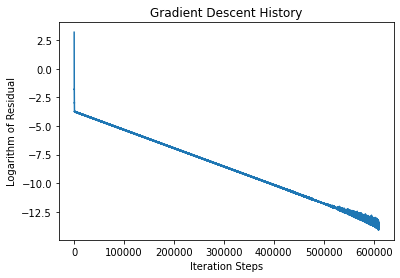

In [47]:
n = 10
np.random.seed(0)
A = np.random.randn(n*n).reshape((n,n))
A = A.T @ A 
# 计算一下收敛因子
eigs = np.linalg.eigvalsh(A)
kappa = eigs[-1]/eigs[0]
print('Coeff =',(kappa-1)/(kappa+1))

realsol = np.random.randn(n)
b = A @ realsol
x , history = SteepestDescent(A,b,iter = 800000,verbose = True)

import matplotlib.pyplot as plt
print('Iteration Steps =',history.size)
plt.plot(range(history.size),np.log10(history)/2.0) # 由于history是 r的范数的平方, 所以取对数后要除以2还原
plt.title('Gradient Descent History')
plt.xlabel('Iteration Steps')
plt.ylabel('Logarithm of Residual')
plt.show()

### 共轭梯度法 (Conjugate Gradient, CG)

还是对于实对称正定矩阵 $A$. 在最速下降法中, 有如下定理: 

**Theorem 2** 最速下降法第 $k$ 步得到的近似解 $x_k$ 满足:
$$x_k\in x_0 + \mathcal K(A,r_0,k).$$

证: 由 $x_{k+1} = x_k - \alpha (Ax_k - b)$, 归纳显然.
<br>

共轭梯度法则是直接希求第 $k$ 步得到的近似解是这个(平移的) Krylov 子空间的最优解:
 $$x_k = {\rm argmin} \{x^TAx - 2x^Tb,\ x\in x_0+ \mathcal  K(A,r_0,k)\}.$$

其迭代规则如下 [3]:

$$\alpha_k = \frac{r_k^Tr_k}{p_k^TAp_k}$$
$$x_{k+1} = x_k + \alpha p_k$$
$$r_{k+1} = r_k - \alpha Ap_k$$
$$\beta_{k+1} = \frac{r_{k+1}^Tr_{k+1}}{r_k^Tr_k}$$
$$p_{k+1} = r_{k+1} + \beta p_k$$

实际操作中, 每步只需做一次矩阵-向量乘法 ( 只计算一次 $Ap_k$ ).

这个方法也可以用 Krylov 子空间理解, 见 [2] p. 634.

In [46]:
def ConjugateGradient(A,b,iter = -1):
    n = A.shape[0]
    x = np.zeros(n,dtype=A.dtype)
    r = b.copy()
    p = r.copy()
    Ap = A @ p
    normr = np.dot(r,r)
    lastnorm = 0
    if iter < 0 : iter = n + 1

    for k in range(iter):
        alpha = normr / np.dot(p, Ap)
        x += alpha * p
        r -= alpha * Ap
        lastnorm = normr
        normr = np.dot(r,r)
        p *= normr / lastnorm
        p += r
        Ap = A @ p
        lastnorm = normr
    
    return x


n = 200
np.random.seed(0)
A = np.random.randn(n*n).reshape((n,n))
A = A.T @ A  + np.eye(n)*3
realsol = np.random.randn(n)
b = A @ realsol
x = ConjugateGradient(A,b)
print('Error    =',np.linalg.norm(realsol - x))
print('Residual =',np.linalg.norm(A @ x - b))


Error    = 2.4511463427363118e-12
Residual = 5.31290905333841e-11


**Theorem 3** 在共轭梯度法的记号中,
$$p_i^Tr_j=0 \ (i<j)$$
$$r_i^Tr_j=0 \ (i\neq j)$$
$$p_i^TAp_j=0\ (i\neq j)$$
$${\rm span}\{x_1,\dotsc,x_{k}\} = {\rm span}\{r_0,\dotsc,r_{k-1}\} = {\rm span}\{p_0,\dotsc,p_{k-1}\} = \mathcal K_k$$

证明见 [1] pp. 146.

**Theorem 4** 假设精确解为 $Ax_* = b$, 共轭梯度法的第 $k$ 步的近似解 $x_k$ 满足:

 $$x_k = {\rm argmin} \{x^TAx - 2x^Tb,\ x\in x_0+ \mathcal  K(A,r_0,k)\}.$$
 $$x_k = {\rm argmin} \{\Vert x - x_*\Vert_A,\ x\in x_0+ \mathcal  K(A,r_0,k)\}.$$

证明见 [1] pp. 148.

**Theorem 5** 共轭梯度法第 $k$ 步的近似解 $x_k$ 满足:
$$\Vert x_k - x_*\Vert_A\leqslant 2\left(\frac{\sqrt \kappa - 1}{\sqrt \kappa +1}\right)^k \Vert x_0 - x_*\Vert_A.$$

证明见 [1] pp. 151. 这说明收敛速度可能与 $\kappa$ 有关, 当 $\kappa$ 过大收敛可能很慢.

### 预条件共轭梯度法 (Preconditioned Conjugate Gradient, PCG)

若实对称正定矩阵 $A$ 的结构已知, 若能找到一个对称正定矩阵 $M \approx A$, 则可以做如下操作:

设其逆矩阵的 Cholesky 分解 $M^{-1} = LL^T$.

$$Ax = b\Leftrightarrow M^{-1}Ax = M^{-1}b \Leftrightarrow LL^TAx = LL^Tb.$$

即
$$(L^TAL)(L^{-1}x) = L^{T}b.$$

若 $M\approx A^{-1}$, 则很可能有 $L^TAL \approx I$, 即其条件数较小, 因此收敛快.

经过计算化简, 若记 $\tilde r_k = M^{-1}r_k$, 则其迭代规则如下 [4]:

$$\alpha_k = \frac{r_k^T\tilde r_k}{p_k^TAp_k}$$
$$x_{k+1} = x_k + \alpha p_k$$
$$r_{k+1} = r_k - \alpha Ap_k$$
$$\tilde r_{k+1} = M^{-1}r_{k+1}$$
$$\beta_{k+1} = \frac{r_{k+1}^T\tilde r_{k+1}}{r_k^T\tilde r_k}$$
$$p_{k+1} = \tilde r_{k+1} + \beta p_k$$

可见每次循环只有唯一一处利用到了 $M$: $\tilde r_{k+1} = M^{-1} r_k$ , 因此要取容易解方程的矩阵 $M$, 如对角阵.

### References

1. 徐树方,高立,张平文, 数值线性代数, The Peking University Press, 2nd ed., 2013.
2. G. Golub and C. Van Loan, Matrix Computations, The Johns Hopkins University Press, Baltimore, Maryland, 4th ed., 2013.
3. http://math.iit.edu/~fass/477577_Chapter_15.pdf
4. http://math.iit.edu/~fass/477577_Chapter_16.pdf